In [108]:
#%pip install pandas
#%pip  install Jinja2
#%pip install matplotlib
#%pip install -U scikit-learn
#%pip install xgboost

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance

# Leer datos y realizar exploratory data anlysis (EDA)

In [110]:
df = pd.read_csv("dataset_SCL.csv", low_memory=False)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


In [111]:
df.head(10)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
5,2017-01-06 23:30:00,226,SCEL,KMIA,AAL,2017-01-07 00:04:00,226,SCEL,KMIA,AAL,7,1,2017,Sabado,I,American Airlines,Santiago,Miami
6,2017-01-07 23:30:00,226,SCEL,KMIA,AAL,2017-01-07 23:25:00,226,SCEL,KMIA,AAL,7,1,2017,Sabado,I,American Airlines,Santiago,Miami
7,2017-01-08 23:30:00,226,SCEL,KMIA,AAL,2017-01-08 23:25:00,226,SCEL,KMIA,AAL,8,1,2017,Domingo,I,American Airlines,Santiago,Miami
8,2017-01-09 23:30:00,226,SCEL,KMIA,AAL,2017-01-10 00:10:00,226,SCEL,KMIA,AAL,10,1,2017,Martes,I,American Airlines,Santiago,Miami
9,2017-01-11 23:30:00,226,SCEL,KMIA,AAL,2017-01-12 00:39:00,226,SCEL,KMIA,AAL,12,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [112]:
df.shape

(68206, 18)

In [114]:
# transformar las fechas a datetime
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])

### Histogramas

Text(0, 0.5, 'Cantidad de vuelos')

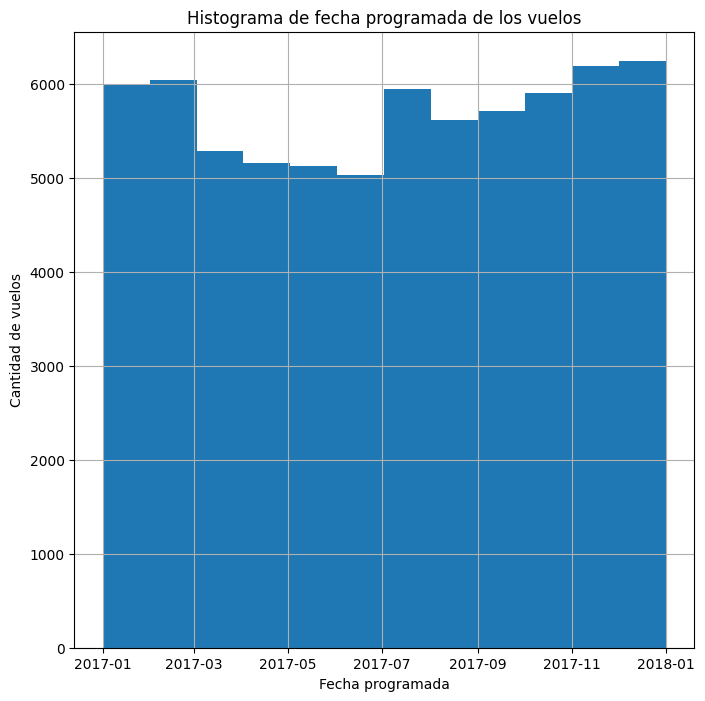

In [115]:
hist1 = df.hist(column='Fecha-I',figsize=(8,8),bins=12)
plt.title('Histograma de fecha programada de los vuelos')
plt.xlabel('Fecha programada')
plt.ylabel('Cantidad de vuelos')

Text(0, 0.5, 'Cantidad de vuelos')

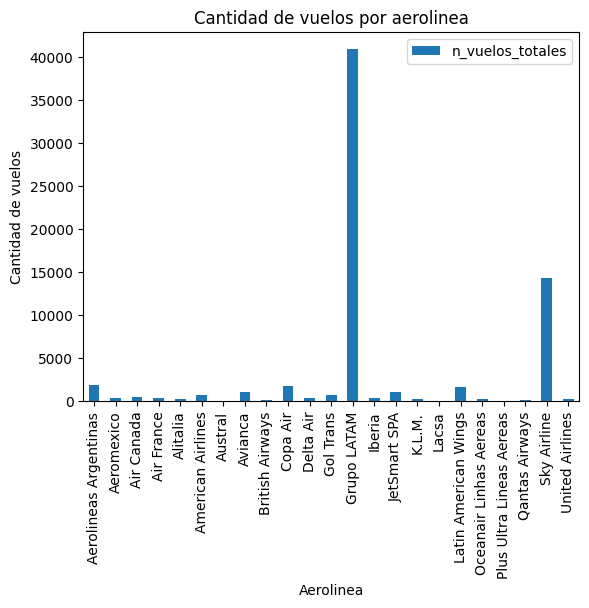

In [168]:
# n de vuelos totales por aerolinea
vuelos_opera = df.groupby(['OPERA'])['OPERA'].count().reset_index(name='n_vuelos_totales')
vuelos_opera.plot(kind='bar', x='OPERA', y='n_vuelos_totales')
plt.title('Cantidad de vuelos por aerolinea')
plt.xlabel('Aerolinea')
plt.ylabel('Cantidad de vuelos')

# Cálculo de clumnas adicionales

In [118]:
temporada_alta = [1 if i > pd.to_datetime('2017-12-15') or i <= pd.to_datetime('2017-03-03') else
                  1 if   pd.to_datetime('2017-07-31') >= i >= pd.to_datetime('2017-07-15') else
                  0 for i in df["Fecha-I"] ]
temporada_alta

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [119]:
dif_fechas = df["Fecha-O"] - df["Fecha-I"]
dif_min = pd.to_timedelta(dif_fechas)/pd.Timedelta('60s')
dif_min

0         3.0
1         9.0
2         9.0
3         3.0
4        -2.0
         ... 
68201    46.0
68202    16.0
68203    40.0
68204    13.0
68205     9.0
Length: 68206, dtype: float64

In [120]:
atraso_15 = [1 if i > 15 else 0 for i in dif_min]
atraso_15

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,


In [121]:
#p = ['mañana' if ]
periodo_dia = ['mañana' if  12 > i.hour >= 5 else
     'tarde'  if  19 > i.hour >= 12 else
     'noche' for i in df["Fecha-I"]]
periodo_dia

['noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'noche',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',
 'tarde',


### Guardar en archivo synthetic_features.csv las columnas adicionales

In [122]:
a = [temporada_alta, periodo_dia, dif_min, atraso_15]
synthetic = pd.DataFrame(a).transpose()
synthetic.columns = ['temporada_alta', 'periodo_dia', 'dif_min', 'atraso_15']
synthetic
# guardar las features adicionales
synthetic.to_csv('synthetic_features.csv',index=False)

,temporada_alta,periodo_dia,dif_min,atraso_15
0,1,noche,3.0,0
1,1,noche,9.0,0
2,1,noche,9.0,0
3,1,noche,3.0,0
4,1,noche,-2.0,0
...,...,...,...,...
68201,1,tarde,46.0,1
68202,1,tarde,16.0,1
68203,1,tarde,40.0,1
68204,1,tarde,13.0,0


### Cálculo de tasas de atraso

In [124]:
# leer featires adicionales
sfeatures = pd.read_csv('synthetic_features.csv')

In [125]:
frames = [df, sfeatures]
data = pd.concat(frames, axis=1, join='inner')
data

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,periodo_dia,dif_min,atraso_15
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,noche,3.0,0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,noche,9.0,0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,noche,9.0,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,noche,3.0,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,noche,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,...,2017,Viernes,I,JetSmart SPA,Santiago,Lima,1,tarde,46.0,1
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,...,2017,Lunes,I,JetSmart SPA,Santiago,Lima,1,tarde,16.0,1
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,2017,Miercoles,I,JetSmart SPA,Santiago,Lima,1,tarde,40.0,1
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,2017,Viernes,I,JetSmart SPA,Santiago,Lima,1,tarde,13.0,0


In [126]:
# n de vuelos totales por destino
vuelos_destino = data.groupby(['SIGLADES'])['SIGLADES'].count().reset_index(name='n_vuelos_totales')
# n de vuelos atrasados por destino
atrasos_destino = data.groupby(['SIGLADES'])['atraso_15'].apply(lambda x: (x==1).sum()).reset_index(name='n_vuelos_atrasados')
frames = [vuelos_destino, atrasos_destino]
tasa_atraso_destino = pd.concat(frames, axis=1, join='inner').iloc[:,[0,1,3]]
tasa_atraso_destino['tasa_atraso'] = (tasa_atraso_destino['n_vuelos_atrasados']/tasa_atraso_destino['n_vuelos_totales'])
tasa_atraso_destino

,SIGLADES,n_vuelos_totales,n_vuelos_atrasados,tasa_atraso
0,Antofagasta,5786,847,0.146388
1,Arica,2436,330,0.135468
2,Asuncion,232,66,0.284483
3,Atlanta,358,21,0.058659
4,Auckland N.Z.,361,135,0.373961
...,...,...,...,...
57,Toronto,283,89,0.314488
58,Tucuman,38,10,0.263158
59,Ushuia,6,4,0.666667
60,Valdivia,753,117,0.155378


In [127]:
# n de vuelos totales por aerolinea
vuelos_destino = data.groupby(['OPERA'])['OPERA'].count().reset_index(name='n_vuelos_totales')
# n de vuelos atrasados por aerolinea
atrasos_destino = data.groupby(['OPERA'])['atraso_15'].apply(lambda x: (x==1).sum()).reset_index(name='n_vuelos_atrasados')
atrasos_destino
frames = [vuelos_destino, atrasos_destino]
tasa_atraso_opera = pd.concat(frames, axis=1, join='inner').iloc[:,[0,1,3]]
tasa_atraso_opera['tasa_atraso'] = (tasa_atraso_opera['n_vuelos_atrasados']/tasa_atraso_opera['n_vuelos_totales'])
tasa_atraso_opera

,OPERA,n_vuelos_totales,n_vuelos_atrasados,tasa_atraso
0,Aerolineas Argentinas,1949,468,0.240123
1,Aeromexico,351,10,0.028490
2,Air Canada,565,258,0.456637
3,Air France,358,30,0.083799
4,Alitalia,259,29,0.111969
5,American Airlines,757,51,0.067371
6,Austral,74,15,0.202703
7,Avianca,1152,306,0.265625
8,British Airways,205,29,0.141463
9,Copa Air,1850,116,0.062703


In [128]:
# n de vuelos totales por mes
vuelos_destino = data.groupby(['MES'])['MES'].count().reset_index(name='n_vuelos_totales')
# n de vuelos atrasados por mes
atrasos_destino = data.groupby(['MES'])['atraso_15'].apply(lambda x: (x==1).sum()).reset_index(name='n_vuelos_atrasados')
atrasos_destino
frames = [vuelos_destino, atrasos_destino]
tasa_atraso = pd.concat(frames, axis=1, join='inner').iloc[:,[0,1,3]]
tasa_atraso['tasa_atraso'] = (tasa_atraso['n_vuelos_atrasados']/tasa_atraso['n_vuelos_totales'])
tasa_atraso

,MES,n_vuelos_totales,n_vuelos_atrasados,tasa_atraso
0,1,6108,978,0.160118
1,2,5561,843,0.151591
2,3,5482,631,0.115104
3,4,5020,585,0.116534
4,5,5240,827,0.157824
5,6,4981,852,0.171050
6,7,5992,1758,0.293391
7,8,5744,996,0.173398
8,9,5610,967,0.172371
9,10,6032,1363,0.225962


In [129]:
# n de vuelos totales por dia de semana
vuelos_destino = data.groupby(['DIANOM'])['DIANOM'].count().reset_index(name='n_vuelos_totales')
# n de vuelos atrasados por dia de la semana
atrasos_destino = data.groupby(['DIANOM'])['atraso_15'].apply(lambda x: (x==1).sum()).reset_index(name='n_vuelos_atrasados')
atrasos_destino
frames = [vuelos_destino, atrasos_destino]
tasa_atraso = pd.concat(frames, axis=1, join='inner').iloc[:,[0,1,3]]
tasa_atraso['tasa_atraso'] = (tasa_atraso['n_vuelos_atrasados']/tasa_atraso['n_vuelos_totales'])
tasa_atraso

,DIANOM,n_vuelos_totales,n_vuelos_atrasados,tasa_atraso
0,Domingo,9796,1578,0.161086
1,Jueves,10251,2045,0.199493
2,Lunes,10131,2048,0.202152
3,Martes,9662,1634,0.169116
4,Miercoles,9722,1661,0.170850
5,Sabado,8352,1363,0.163194
6,Viernes,10292,2285,0.222017


In [130]:
# n de vuelos totales por temporada
vuelos_destino = data.groupby(['temporada_alta'])['temporada_alta'].count().reset_index(name='n_vuelos_totales')
# n de vuelos atrasados por temporada
atrasos_destino = data.groupby(['temporada_alta'])['atraso_15'].apply(lambda x: (x==1).sum()).reset_index(name='n_vuelos_atrasados')
atrasos_destino
frames = [vuelos_destino, atrasos_destino]
tasa_atraso = pd.concat(frames, axis=1, join='inner').iloc[:,[0,1,3]]
tasa_atraso['tasa_atraso'] = (tasa_atraso['n_vuelos_atrasados']/tasa_atraso['n_vuelos_totales'])
tasa_atraso

,temporada_alta,n_vuelos_totales,n_vuelos_atrasados,tasa_atraso
0,0,49592,8842,0.178295
1,1,18614,3772,0.202643


In [131]:
# n de vuelos totales por tipo de vuelo
vuelos_destino = data.groupby(['TIPOVUELO'])['TIPOVUELO'].count().reset_index(name='n_vuelos_totales')
# n de vuelos atrasados por tipo de vuelo
atrasos_destino = data.groupby(['TIPOVUELO'])['atraso_15'].apply(lambda x: (x==1).sum()).reset_index(name='n_vuelos_atrasados')
atrasos_destino
frames = [vuelos_destino, atrasos_destino]
tasa_atraso = pd.concat(frames, axis=1, join='inner').iloc[:,[0,1,3]]
tasa_atraso['tasa_atraso'] = (tasa_atraso['n_vuelos_atrasados']/tasa_atraso['n_vuelos_totales'])
tasa_atraso

,TIPOVUELO,n_vuelos_totales,n_vuelos_atrasados,tasa_atraso
0,I,31240,7048,0.225608
1,N,36966,5566,0.150571


### Preprocesamiento y entrenamiento del modelo

In [132]:
# definir set de train, val y test
dataset1 = data[['DIA','MES','DIANOM','TIPOVUELO','OPERA', \
                'SIGLADES','temporada_alta', 'periodo_dia']]
target = data[['atraso_15']]
target

,atraso_15
0,0
1,0
2,0
3,0
4,0
...,...
68201,1
68202,1
68203,1
68204,0


In [144]:
# analizar el balance de clases
target.groupby(['atraso_15'])['atraso_15'].count().reset_index(name='n_vuelos_totales')

,atraso_15,n_vuelos_totales
0,0,55592
1,1,12614


In [133]:
# %% one-hot encoding para variables categoricas
cols = dataset1.columns
num_cols = dataset1._get_numeric_data().columns
cat = list(set(cols) - set(num_cols))
full_pipeline = ColumnTransformer([('cat2', OneHotEncoder(handle_unknown='ignore'), cat)],\
                 remainder='passthrough')
# aplicar transformacion al set de entrenamiento
dataset1 = full_pipeline.fit_transform(dataset1)
# normalizar 
#scaler = MinMaxScaler()
#dataset1 = scaler.fit_transform(dataset1)
type(dataset1)


scipy.sparse._csr.csr_matrix

In [135]:
x_train, x_test, y_train, y_test = train_test_split(dataset1, target,
                                                     test_size=0.20, random_state=42)

In [147]:
# %% Grid search
# se define model
model = XGBClassifier()
 #%%
print()
print('Efectuando 10-Cross Validation y Grid Search para \
 \noptimizacion del hiperparametro scale_post_weight de XGBoost ')
# definir la grilla
weights = [1, 2]
param_grid = dict(scale_pos_weight=weights)
# definir el metodo de evaluacion
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#  grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# ejecutar el grid search
grid_result = grid.fit(x_train, y_train)
# mejores resultados
print("Mejor Modelo: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
print()
# 
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("ROC AUC promedio %f  : %r" % (mean, param))


Efectuando 10-Cross Validation y Grid Search para  
optimizacion del hiperparametro scale_post_weight de XGBoost 
Mejor Modelo: 0.357007 usando {'scale_pos_weight': 2}

ROC AUC promedio 0.220009  : {'scale_pos_weight': 1}
ROC AUC promedio 0.357007  : {'scale_pos_weight': 2}


In [148]:
grid_result.best_score_

0.35700729827335326

In [139]:
for mean, param in zip(means, params):
    print("ROC AUC promedio %f  : %r" % (mean, param))

ROC AUC promedio 0.722058  : {'scale_pos_weight': 1}
ROC AUC promedio 0.720252  : {'scale_pos_weight': 2}
ROC AUC promedio 0.719936  : {'scale_pos_weight': 2.3333333333333335}
ROC AUC promedio 0.719102  : {'scale_pos_weight': 3}
ROC AUC promedio 0.717449  : {'scale_pos_weight': 4}
ROC AUC promedio 0.717296  : {'scale_pos_weight': 5}
ROC AUC promedio 0.713854  : {'scale_pos_weight': 10}
ROC AUC promedio 0.707968  : {'scale_pos_weight': 25}
ROC AUC promedio 0.703656  : {'scale_pos_weight': 50}
ROC AUC promedio 0.701758  : {'scale_pos_weight': 75}
ROC AUC promedio 0.701299  : {'scale_pos_weight': 100}


In [149]:
# %% Modelo Final
scale_pos = grid_result.best_params_['scale_pos_weight']
#%
model = XGBClassifier(**grid_result.best_params_)
model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

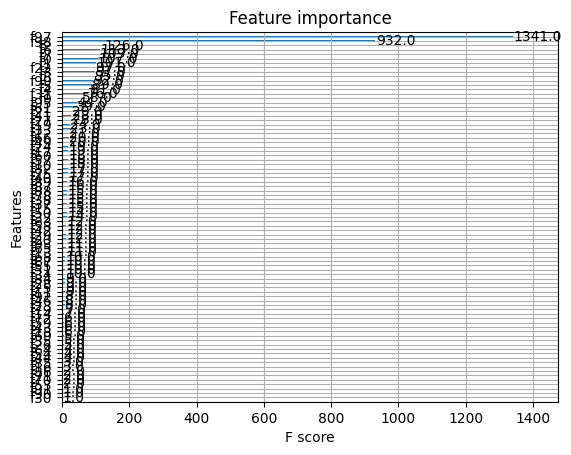

In [150]:
# plot feature importance
plot_importance(model)
pyplot.show()